# Portfolio Task 3: Time series forecasting - ANN

## Introduction

The forecasting analysis covers the daily exchange rate from `January 4, 2010 to August 7, 2020`, with a focus on the value of the British pound to the US dollar, showing a decreasing trend with fluctuations.

## Key Findings

- The predicted `GBP/USD` exchange rate for 08 `Aug 2020` is expected to experience a slight decrease.

- The changes in the `GBP/USD` exchange rate show dependence primarily on the most recent rate, but this does not fully capture the complexity of exchange rate movements. Other factors, including economic indicators, market sentiment, and external shocks can be considered to make a more acurrate forecast.

- The ARNN model can accurately predicts the next-day `GBP/USD` exchange rate when provided with known lag/input values. However, when using predicted values as inputs for longer-term forecasts, the model struggles to accurately capture the exchange rate pattern. 
  
- For reliable long-term predictions, a more advanced approach is required (LSTM, or an Hybrid Model), one that incorporates additional economic indicators beyond historical rates and utilises a more complex model to effectively capture complex market dynamics.

## Tasks

Forecast the exchange rate for `August 8, 2020` using an `Artificial Neural Network`

[1. Analyse data and indicate the number of inputs and outputs and the values for them in a separate file (in Excel or SPSS). Why do you select your inputs and outputs, is there any analysis supporting your choices?](#3_1)

[2. Use the neural network and train a suitable model for your data. Report the tables and diagrams you get as an output from the SPSS and interpret the results in the report. Explain your neural network with details and provide the performance analysis for the method. Is the model you proposed a good model? How do you support your claim? Also provide the table of preferences for the input values and interpret it.](#3_2)

## The Project Directory

The Portfolio 3 Project files can be found in the Github Repository: [github.com/lamtong/portfolio3_gbp_usd_arnn](https://github.com/lamtong/portfolio3_gbp_usd_arnn)

## I. Data Pre-processing

In [62]:
# Import packages
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sys
import os
from keras.utils import plot_model
import graphviz
from keras.callbacks import EarlyStopping
from sklearn.inspection import permutation_importance

sys.path.append(os.path.abspath("../.."))
from shared_files.custom_plots import plot_props  # Import the customise plot module

import warnings
# Ignore FutureWarnings
warnings.filterwarnings("ignore", 
                        category = FutureWarning)  

# Ignore SettingWithCopyWarning
warnings.simplefilter(action="ignore", 
                      category = pd.errors.SettingWithCopyWarning) 

In [63]:
# Import datasets
df = pd.read_excel('exchange-rate-uk-us-data.xlsx')

# Split the set
df_metadata = df.loc[:8]    # the data info
df          = df.loc[10:]   # the main dataset for analysis

# Rename column
df = df.rename(columns = {df.columns[0]: 'date', 
                        df.columns[1]: 'DEXUSUK'})

# Casting 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

#### 1. Nulls and Duplicates handling:

**Missing Values:**

In [64]:
# Number of NULL in 'DEXUSUK'
no_null = df['DEXUSUK'].isnull().sum()
print(f'\nNumber of missing values in "DEXUSUK": {no_null}')


Number of missing values in "DEXUSUK": 110


**Duplicated Records:**

In [65]:
# Checking duplicate records
print(f'Number of Duplicated Records: {df.duplicated().sum()}')

Number of Duplicated Records: 0


#### 2. Imputation: 

**Missing Values Replacement:** Using `Forward Fill` (Carries the last valid observation forward) to replace the missing value.

In [66]:
# forward fill
df['DEXUSUK'].fillna(method = 'ffill', inplace = True)

## II. Portfolio 3 Tasks

<a name="3_1"></a>
### 1. Analyse Data and indicate the number of Inputs, Outputs, and their values in a separate file

#### 1.1. The Original Series of `GBP/USD` Exchange Rate:

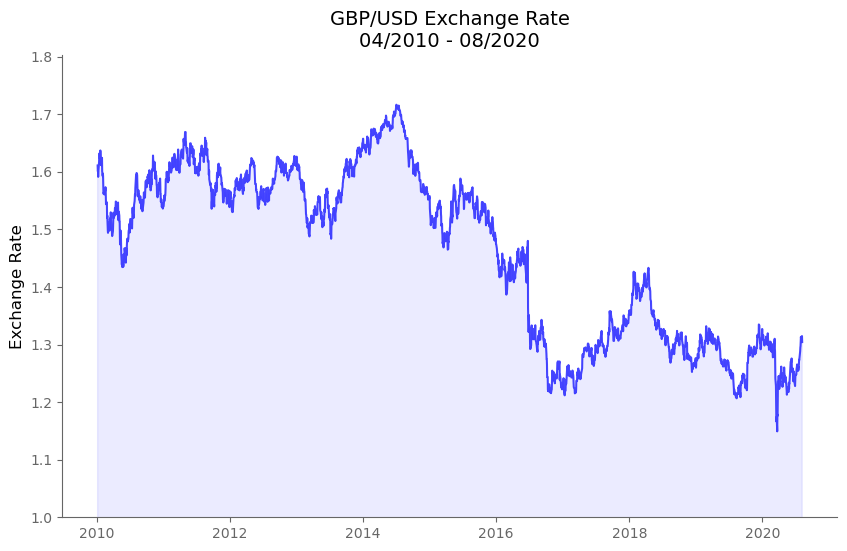

In [67]:
# Plot the original time series data
plt.figure(figsize=(10, 6))
sns.lineplot(x     =  df['date'],
             y     =  df['DEXUSUK'],
             color = 'blue',
             alpha = 0.7) 
plt.fill_between(df['date'], df['DEXUSUK'], color = 'blue', alpha=.08) 

# Show the plot
plt.ylim(bottom = 1)
plot_props(title          = 'GBP/USD Exchange Rate\n04/2010 - 08/2020', 
           y_label        = 'Exchange Rate',
           legend         = False)

#### 1.2. Number of Inputs and Outputs:

**Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots**:

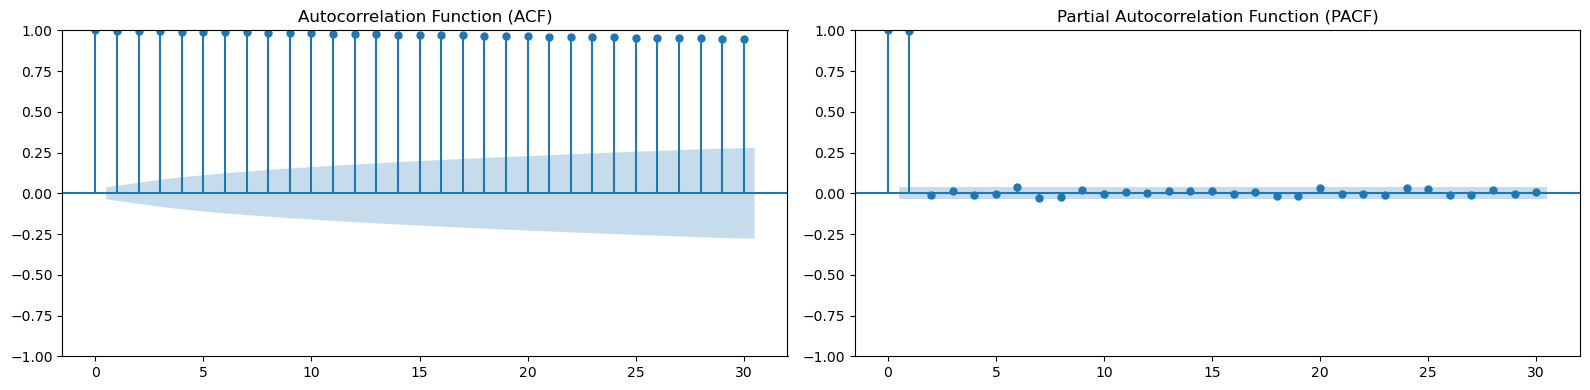

In [68]:
def auto_cor(series):

    # Plot ACF and PACF for the original series
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    # ACF plot
    plot_acf(series, lags=30, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    # PACF plot
    plot_pacf(series, lags=30, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

auto_cor(df['DEXUSUK'])

**The ARNN Model's Inputs and Ouputs:**
- **Input:** Based on the PACF plot, only the first lag is significant, thus the ARNN model will have `one input`, which is the value of the first lag, or the exchange rate of the previous day.
- **Output:** The goal is to predict the next day value of `GBP/USD` exchange rate, then there is `one output` of the model, which is the predicted `GBP/USD` exchange rate.

#### 1.3. Export the Training Data file of The Neural Network to *exchange_rate_GBP_USD.csv*:

**Normalisation:** Using *Min-Max Scaler* to scale the data (the Exchange Rate and its lag) to a fixed range, `between 0 and 1`. In order to preserve the relationships between the original data values while making the data suitable for models that are sensitive to magnitude differences like the Neural Networks. The *Min-Max Scaler* transforms each value $x_i$ using the formula:

$$x_{Scaled} = \frac{x_i - \min(X)}{\max(X) - \min(X)}$$


In [69]:
# Initiate the Number of Lags as Inputs
lag_num = 1

def add_lags(data, series, num_lags):
    '''This function add the collumns of normalised lags for the ANN Model

    Arguments:
        data -- the data series
        num_lags -- desired number of lags
    '''
    # Add new rows with all columns as NaN, using new date
    for i in range(1, num_lags+1):
        # Compute the next date: add one day to the last date in the index
        new_date = data.index[-1] + 1
        
        # Assign a new row with the new_date as the index
        data.loc[new_date] = [None] * len(data.columns)
        # Lag column added
        data[f'lag_{i}_scaled'] = data[series].shift(i)  

# Normalize GBP/USD exchange rates
scaler = MinMaxScaler(feature_range=(0, 1))
df['DEXUSUK_scaled'] = scaler.fit_transform(df[['DEXUSUK']])

# adding corresponding columns of lags values
add_lags(df, 'DEXUSUK_scaled', lag_num)

# export the time series dataset to "exchange_rate_GBP_USD.csv"
df.to_csv('exchange_rate_GBP_USD.csv', index=False)

**The Dataset containing the normalised values and lags values:**

In [70]:
# Show the lags dataset
df.head()

,date,DEXUSUK,DEXUSUK_scaled,lag_1_scaled
10,2010-01-04,1.6109,0.813855,NaN
11,2010-01-05,1.6009,0.796228,0.813855
12,2010-01-06,1.6016,0.797462,0.796228
13,2010-01-07,1.5912,0.779129,0.797462
14,2010-01-08,1.5993,0.793407,0.779129


<a name="3_2"></a>
### 2. Use the Neural Network and train a suitable Model for the Data. 

**2.1.** Report the tables and diagrams as an output from the SPSS (or any equivalent) and interpret the results in the report. 

**2.2.** Explain the neural network with details and provide the performance analysis for the method. 

**2.3.** Is the model you proposed a good model? How do you support the claim? Also provide the table of preferences for the input values and interpret it.

**2.4.** Forecast the Exchange GBP/USD Exchange Rate in `August 8 2020`

#### Prepare the Training and Testing Data:

- **Training and Validation set:** `80%` Data
- **Holdout set:** `20%` Data

In [71]:
# Split into train and test
X = df.loc[:, [f'lag_{n}_scaled' for n in range(1, lag_num+1)]].loc[df.index[lag_num:-lag_num]]
y = df['DEXUSUK_scaled'].loc[df.index[lag_num:-lag_num]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#### The Autoregressive Neural Network (ARNN) Model:

In [72]:
# Define Neural Network model (Fully Connected Feedforward)
model = keras.Sequential([
        keras.layers.Dense(5, activation = "sigmoid", input_shape=(lag_num,)),
        keras.layers.Dense(1, activation = "linear")])  # Output single forecasted value

# Compile the model
model.compile(optimizer="adam", loss="mse") #  Stochastic Gradient Descent Algorithm

# setting the early stopping for the lowest validation lost
early_stopping           = EarlyStopping(
    monitor              = 'val_loss',    # Monitor validation loss
    patience             = 10,            # wait before stopping
    restore_best_weights = True # Restore the best model
)

# Train the model
history = model.fit(X_train, y_train, 
          validation_split = 0.15, 
          epochs           = 100, 
          batch_size       = 4,
          callbacks        = [early_stopping],
          verbose          = 1)

# Make predictions
predictions = model.predict(X_test)

Epoch 1/100


c:\Users\blueb\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - loss: 0.0186 - val_loss: 0.0454
Epoch 2/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.0093 - val_loss: 0.0226
Epoch 3/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 0.0048 - val_loss: 0.0083
Epoch 4/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 5/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 8.1948e-04 - val_loss: 6.1228e-04
Epoch 6/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 3.1194e-04 - val_loss: 1.6678e-04
Epoch 7/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 2.5694e-04 - val_loss: 1.5477e-04
Epoch 8/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 2.4455e-04 - val_loss: 2.0447e-04
Epoch 9/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 2.7016e-04 - val_loss: 1.8420e-04
Epoch 10/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 2.7755e-04 - val_loss: 1.9053e-04
Epoch 11/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 3.0428e-0

In [73]:
# Save entire model (architecture + weights + optimizer)
model.save("best_model.keras")  

#### 2.1. Report the Tables and Diagrams as an output from the SPSS (or any equivalent) and interpret the results:

**The Neural Network Diagram:**

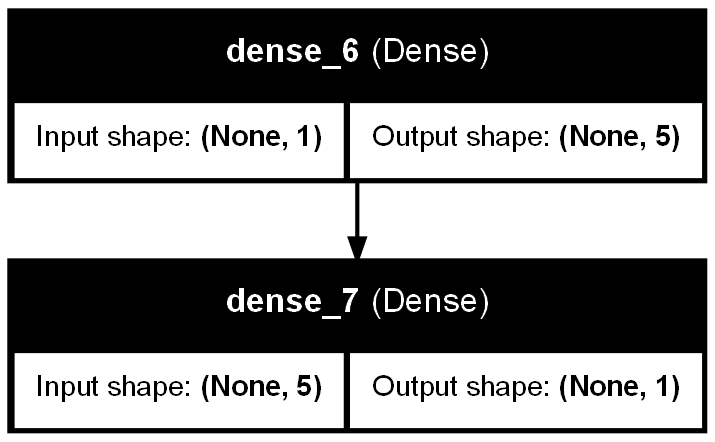

In [74]:
# Visualize the Model
plot_model(model, 
           to_file="model.png", 
           show_shapes=True, 
           show_layer_names=True, 
           dpi = 150) 

**Parameter Estimates (Weights):**

In [75]:
# showings the trainings weights of the trained model
for layer in model.layers:
    print(layer.name, layer.get_weights())

dense_6 [array([[ 1.0720649 , -0.66931283, -0.572004  ,  1.0883771 ,  1.4232397 ]],
      dtype=float32), array([-0.27266645,  0.15092316,  0.13867413, -0.27750474, -0.4402197 ],
      dtype=float32)]
dense_7 [array([[ 0.6080895 ],
       [-1.0734112 ],
       [-0.6392374 ],
       [ 0.74297696],
       [ 1.1124703 ]], dtype=float32), array([-0.10671033], dtype=float32)]


**`GBP/USD` Exchange Rate Predictions on the Holdout set:**

Comparing the actual Exchange Rate and its Predictions.

In [76]:
# Rescale predictions back to original values
y_test_rescaled = scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(predictions)

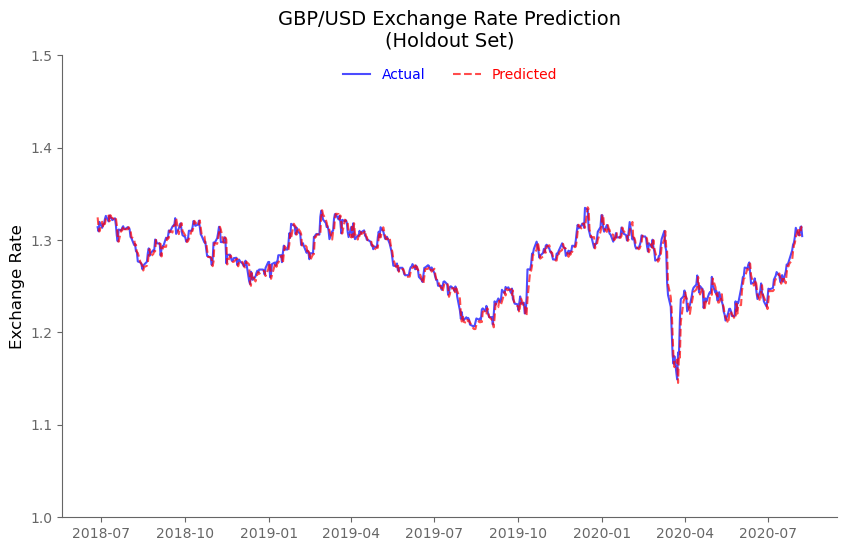

In [77]:
# create dataframe of testing/prediction results
df_test = y_test.to_frame()
df_test['y_test_rescaled'] = y_test_rescaled.flatten()
df_test['y_pred_rescaled'] = y_pred_rescaled.flatten()

# merge with df to get the date
df_comp  =  pd.merge(left = df,
            right         = df_test,
            left_index    = True,
            right_index   = True,
            how           = 'inner')

# create plots
plt.figure(figsize=(10, 6))

# actual plot
sns.lineplot(x     = df_comp['date'],
             y     = df_comp['y_test_rescaled'], 
             color = 'blue',
             alpha = 0.7,
             label = "Actual")

# prediction plot
sns.lineplot(x         = df_comp['date'],
             y         = df_comp['y_pred_rescaled'], 
             color     = 'red',
             alpha     = 0.7,
             label     ="Predicted", 
             linestyle ="dashed")

# y limits
plt.ylim(1,1.5)
# Plot results
plot_props(title   = 'GBP/USD Exchange Rate Prediction\n(Holdout Set)',
           y_label = 'Exchange Rate',
           lgn_loc = 'upper center',
           lgn_col = 2)

**Conclusions about the Model Results:**

- The `ARNN Model` was trained sucessfully as expected and stopped at epoch `29th` as it returned the minimal validation loss.
- The Actual vs. Prediction Graph on Holdout set depicts a very good predictions of the model based on the most recent past value, as the prediction line aligns very closely with the actual exchange rate.

#### 2.2. Explain the Neural Network with details and provide the Performance Analysis for the Method:

The `Autoregressive Neural Network` (`ARNN`) was trained to predict today's exchange rate using the exchange rate from the previous day. The model consists of `one hidden layer` with `5 perceptrons`, optimized using the `ADAM` algorithm. The training process was limited to a maximum of `100 epochs`, and the model with the `lowest validation` loss was selected to ensure a good generalisation of the data.

**The ARNN Model Information:**

- Type: `Fully Connected Feed-forward`
- Samples size:
  - Training: `68%`
  - Validation: `12%`
  - Holdout: `20%`
- Input: `1`
- Output: `1`
- Hidden Layer: `1` (with `5 perceptrons`)
- Activation Function: `Sigmoid` (Hidden layer), `Linear/Identify` (Output layer)
- Optimise Algorithm: `Adaptive Moment Estimation` (`ADAM`) algorithm
- Max Epoch: `100`, automatically stop after `10` training cycles without lower validation loss, and retrieve the one with the lowest validation loss.
- Batch size: `4`

**Model Performance Evaluations:**

- Low training loss values of `0.0001`: The model is learning well.
- `Training loss` > `Validation loss`: The model is not overfitted.
- `Validation loss` is at the minimal of `0.00025`: The model is well-generalised to unseen data.

In [78]:
# Find the epoch with the lowest validation loss
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

# Get the corresponding training and validation loss
best_training_loss = history.history['loss'][best_epoch]
best_valid_loss    = history.history['val_loss'][best_epoch]

print(f"Best epoch: {best_epoch + 1}")  # +1 because epochs start from 1
print(f"Training loss at best epoch: {best_training_loss:.6f}")
print(f"Validation loss at best epoch: {best_valid_loss:.6f}")

Best epoch: 29
Training loss at best epoch: 0.000251
Validation loss at best epoch: 0.000140


**Errors:**

- **Relative Error** (`0.00425`): This is a very low error, indicating that the model makes predictions with high accuracy relative to the actual values. This suggests that the model is well-fitted to the data and generalises well.
- **Sum of Squared Errors** (`0.032`): SSE is the total squared difference between actual and predicted values. A lower SSE means fewer errors overall, which is a positive sign.

In [79]:
# Compute Errors
rle = np.mean(np.abs(df_comp['y_test_rescaled'] - df_comp['y_pred_rescaled']) / np.abs(df_comp['y_test_rescaled'])) # relative errors
sse = np.sum((df_comp['y_test_rescaled'] - df_comp['y_pred_rescaled']) ** 2) # sum of squared errors
mse = np.mean((df_comp['y_test_rescaled'] - df_comp['y_pred_rescaled']) ** 2) # mean squared errors

# show error terms
print("Relative Error:", rle)
print("Sum of Squared Errors (SSE):", sse)
print("Mean Squared Errors (MSE):", mse)

Relative Error: 0.004406437042597284
Sum of Squared Errors (SSE): 0.032431828251005906
Mean Squared Errors (MSE): 5.864706736167433e-05


#### 2.3. Is the Model a good Model? The Table of Preferences for the Input values and its interpretation:

**The Model Predictions and Residual Plots:**

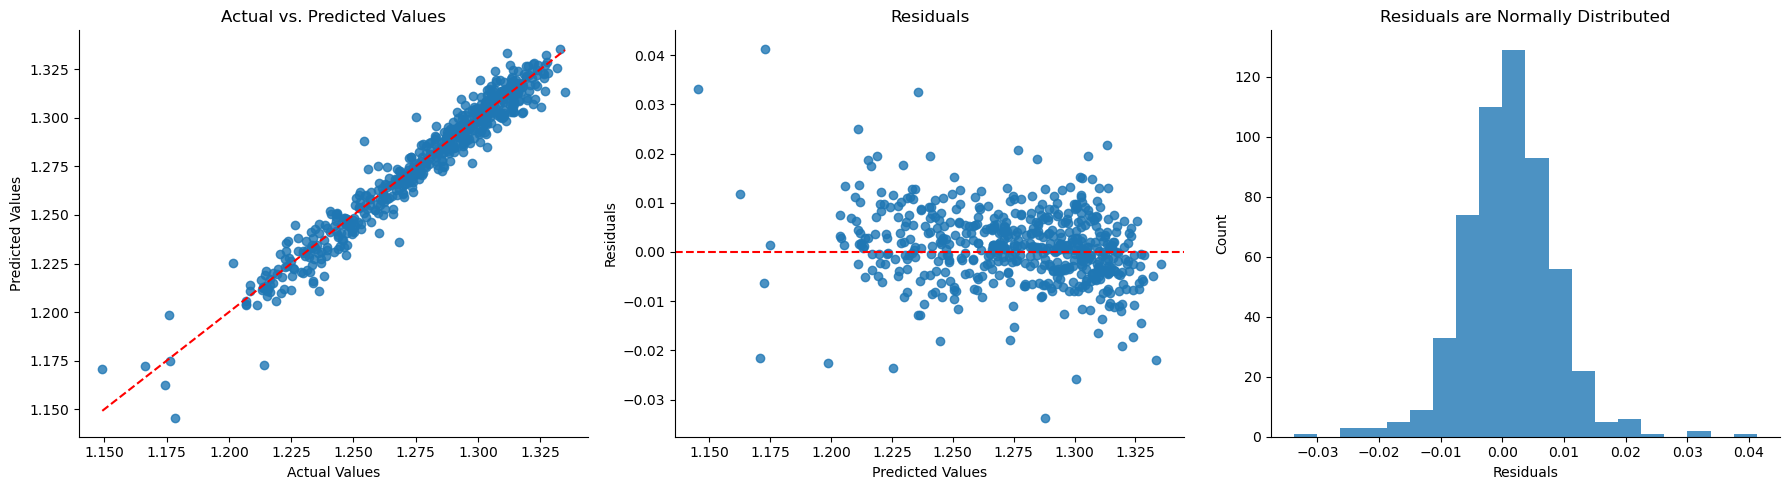

In [80]:
# 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

# ======= Actual vs Predicted Plot =======
axes[0].scatter(df_comp['y_test_rescaled'], df_comp['y_pred_rescaled'], alpha=0.8)
x = np.linspace(df_comp['y_test_rescaled'].min(), df_comp['y_test_rescaled'].max(), 100)
y = x
axes[0].plot(x, y, color='red', linestyle='dashed')
axes[0].set_xlabel("Actual Values")
axes[0].set_ylabel("Predicted Values")
axes[0].set_title("Actual vs. Predicted Values")

# ======= Residual Plot =======
residuals = df_comp['y_test_rescaled'] - df_comp['y_pred_rescaled']
axes[1].scatter(df_comp['y_pred_rescaled'], residuals, alpha=0.8)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel("Predicted Values")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals")

# ======= Residual Histogram =======
axes[2].hist(residuals, alpha=0.8, bins=20)
axes[2].set_xlabel("Residuals")
axes[2].set_ylabel("Count")
axes[2].set_title("Residuals are Normally Distributed")

# Remove spines and adjust layout
sns.despine()
plt.tight_layout()
plt.show()

**The Table of Preferences for the Input values:**

Importance of the First Input (`0.1013`): This number represents how important the `lag_1_scaled` feature is for the model’s predictions. The importance score suggests that this feature contributes `10.13%` to the model’s predictive power.

In [81]:
feature_names = X_train.columns.tolist()

# Compute feature importance using validation data
result = permutation_importance(model, X_train, y_train, scoring='neg_mean_squared_error')

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,  # Replace with actual feature names
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

feature_importance_df

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


,Feature,Importance
0,lag_1_scaled,0.101312


**Conclusions:**

- Overall, the ARNN Model is a good model with low errors on holdout set with very few outliers around `+-0.03`, no sign of overfitting and genrealises the data well.
- The Prediction Residuals on holdout set is normally distributed around `0`. Predicted values mostly scatter around the perfect prediction line.
- The Importance value of `0.1` suggests that `lag_1_scaled` has a moderate impact on the model's predictions. It is reasonable for the first lag to have moderate to high importance, especially in time series models where past values often influence future predictions.

#### 2.4. Forecast the Exchange `GBP/USD` Exchange Rate in `August 8 2020`: 

In [82]:
# the prediction date
pred_date = '2020-08-08'

# Assign Aug 8 datetime value to the last `lag_num` rows
df.loc[df.index[len(df) - lag_num], 'date'] = np.datetime64(pred_date)

# the lag column names
lag_columns = [f'lag_{i}_scaled' for i in range(1, lag_num + 1)]

def predict(date):
    '''This function perform the forecast of 'DEXUSUK_scaled' using the trained ARNN Model 

    Arguments:
        date -- the index of the predicting date on the df
    '''
    # Slice the previous lag days
    prev_values = df['DEXUSUK_scaled'].loc[date - lag_num: date - 1].values.flatten()[::-1]

    # Assign the array to the lags corresponding to the current date
    df.loc[date, lag_columns] = prev_values

    # Convert to DataFrame with column names
    df_temp = pd.DataFrame(prev_values.reshape(1, -1), columns=lag_columns)

    # Set index as a specific date
    df_temp.index.values[0] = date

    # Predict based on the previous values
    prediction = model.predict(df_temp)  

    # Assign the prediction to the current 'DEXUSUK'
    df.at[date, 'DEXUSUK_scaled'] = prediction
    df.at[date, 'DEXUSUK']  = scaler.inverse_transform(prediction)
    
predict(df.index[df['date'] == pred_date][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


**The forecasted `GBP/USD` Exchange Rate on `8 Aug 2020`:** `1.303954`

In [83]:
# show the Predicted value for 8 Aug 2020
df.tail(1)

,date,DEXUSUK,DEXUSUK_scaled,lag_1_scaled
2775,2020-08-08,1.303954,0.272791,0.2734


**The forecasted `GBP/USD` Exchange Rate on `8 Aug 2020` Plot:**

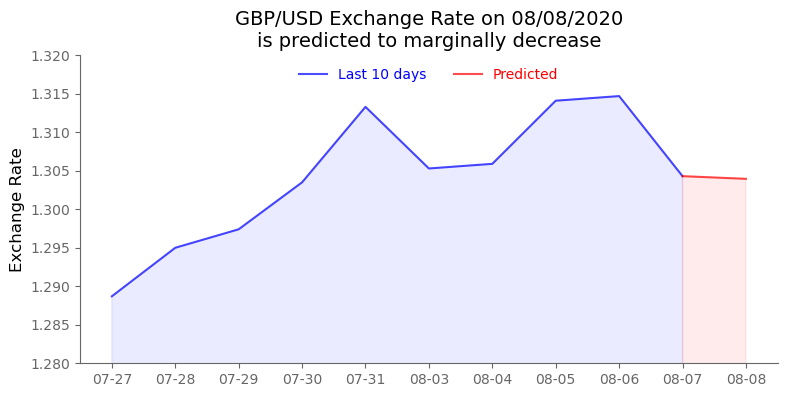

In [91]:
# Plot the original time series data
plt.figure(figsize=(9, 4))

# Last 7 days
sns.lineplot(x     =  df['date'].dt.strftime('%m-%d').iloc[- 11 :- 1],
             y     =  df['DEXUSUK'].iloc[- 11 :- 1],
             color = 'blue',
             alpha = 0.7,
             label = 'Last 10 days') 
plt.fill_between(df['date'].dt.strftime('%m-%d').iloc[- 11 :- 1], 
                 df['DEXUSUK'].iloc[- 11 : -1], 
                 color = 'blue', 
                 alpha = .08) 

# Prediction
sns.lineplot(x     =  df['date'].dt.strftime('%m-%d').iloc[-2:],
             y     =  df['DEXUSUK'].iloc[-2:],
             color = 'red',
             alpha = 0.7,
             label = 'Predicted') 
plt.fill_between(df['date'].dt.strftime('%m-%d').iloc[-2:], 
                 df['DEXUSUK'].iloc[-2:], 
                 color = 'red', 
                 alpha = .08) 

# Show the plot
plt.ylim(1.28, 1.32)
plot_props(title          = 'GBP/USD Exchange Rate on 08/08/2020\nis predicted to marginally decrease', 
           y_label        = 'Exchange Rate',
           lgn_loc        = 'upper center',
           lgn_col        = 2)